# SToP Search String

In [111]:
import csv

#Loading Bar
from ipywidgets import IntProgress
from IPython.display import display
import time

#String Search library
import re

#write to xls format
from openpyxl.styles import Font
from openpyxl.utils import get_column_letter
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl import Workbook
from openpyxl import load_workbook

#Path
import os.path

fname = "Stop_searchstring.xlsx"

#Writing to Excel
if os.path.isfile(fname):
    wb = load_workbook(fname) #If the File already exists
else:
    wb = Workbook() #Create the File

In [133]:
community_string = "Community4"

# open the file in the write mode
f = open('{}.csv'.format(community_string), 'w', newline='')
# create the csv writer
writer = csv.writer(f, delimiter=',')

ws = wb.create_sheet('{}'.format(community_string))

ws.cell(row = 1, column = 1).value = "Searchstring"
ws.cell(row = 1, column = 2).value = "Count"

row_number = 2

In [134]:
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_{}_2017-Present_deidentified.csv'.format(community_string)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
        
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    
    Med_Array.append([ID, Product_Name, Start_Date])
    
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_{}_2017-Present_deidentified.csv'.format(community_string)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 1 - Date
# 3 - Presenting Complaint
# 4 - Primary Presenting Complaint
# 5 - Other Complaints
# 6 - Diagnosis
# 10 - Hour of Date Of Birth
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Date = data[a][1]
    Presenting_complaint = data[a][3]
    Primary_presenting_complaint = data[a][4]
    Other_complaints = data[a][5]
    Diagnosis = data[a][6]
    DOB = data[a][10]
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB])

Med_Array contains some duplicates. Remove the duplicates for much less data combined data

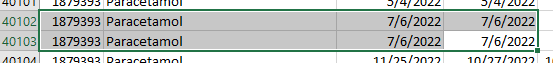

In [135]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [136]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)
UID = []
for a in range (0, len(new_Med_Array)):
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

In [137]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=678, min=1)

In [138]:
#Count missing linkage parts
count_missing_prog = 0
count_missing_med = 0
for a in range (0, len(Data_Array)):
    if len(Data_Array[a][1]) == 0:
        count_missing_prog = count_missing_prog + 1
    if len(Data_Array[a][0]) == 0:
        count_missing_med = count_missing_med + 1
        
print(count_missing_prog, count_missing_med)

0 52315


In [733]:
# Search for the search terms

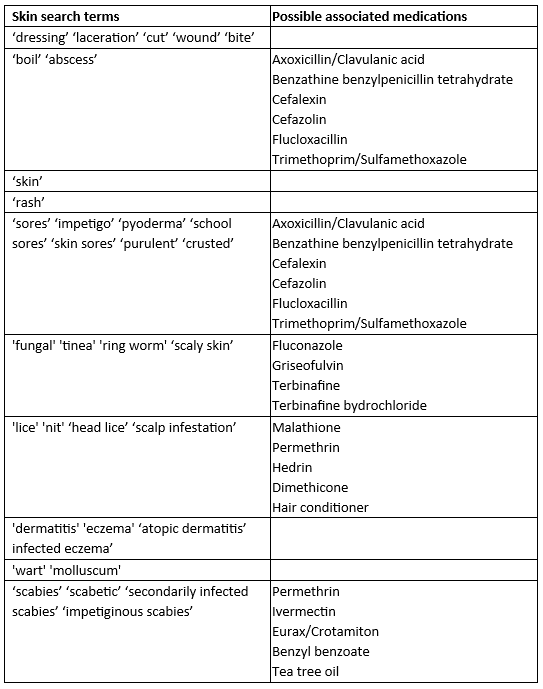

## Search 1 ["dressing", "laceration", "cut", "wound", "bite"]

In [139]:
import datetime
from datetime import datetime

from fuzzywuzzy import fuzz

In [140]:
search = ["dressing", "laceration", "cut", "wound", "bite"]
notBox = ["ulceration", "exacerbation", "exaceration", "lactation"]
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
dressing
2028 dressing dressing, 94 ['', 'wound', 'r/w', 'and', 'dressing,', '', '', '', '']
4648 dressing dressings 94 ['', 'wound', 'dressings', '', '', '', '']
5084 dressing dressings 94 ['', 'mental', 'health', 'review,', 'wound', 'dressings', '', '', 'marijuana', 'user', '']
7047 dressing dressings 94 ['', 'right', 'leg', 'dressings', '', '', '', '']
7175 dressing dressing. 94 ['', 'wound', 'dressing.', 'ivabs', '', '', '', '']
9341 dressing dressing, 94 ['', 'wound', 'dressing,', 'acr,', 'hcg,', 'retinal', 'screening,', 'ecg', '', '', '', '']
13367 dressing dressing, 94 ['', 'burn', 'dressing,', 'anaemia', '', '', 'osteomyelitis', 'of', 'hand', '']
23058 dressing dressings 94 ['', 'dressings', '+', 'discussion', 'u/s', '', '', '', '']
38780 dressing dressing/ 94 ['', 'dressing/', 'review.', '', '', '', '']
43884 dressing redressing 89 ['', '', 'medicine', 'given', '', 'redressing', '']
46061 dressing dressing. 94 ['', 'wound', 'dressing.', 'flu', 'injectio

In [41]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 232 dressing
1 195 laceration
2 24 cut
3 1159 wound
4 234 bite


In [42]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for Mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 2 ["boil", "abscess"]

In [141]:
search = ["boil", "abscess"]
notBox = []
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
boil
1824 boil boils 89 ['', '', 'uti', '-', 'urinary', 'tract', 'infection', 'multiple', 'boils', 'uti', '-', 'urinary', 'tract', 'infection', '']
2647 boil boils 89 ['', '', 'pain', 'boils', 'of', 'multiple', 'sites', '', '']
2647 boil boils 89 ['', '', 'multiple', 'boils', '', '', '']
2663 boil boils 89 ['', '', 'multiple', 'boils', 'superficial', 'injury', 'of', 'gum', 'with', 'infection', 'superficial', 'injury', 'of', 'gum', 'with', 'infection', '']
2679 boil boils 89 ['', '', 'multiple', 'boils', '', '', '']
2681 boil boils 89 ['', '', 'boils', 'of', 'multiple', 'sites', '', '', '']
2854 boil boils 89 ['', '', 'multiple', 'boils', '', '', '']
3766 boil boils 89 ['', '', 'boils', 'of', 'multiple', 'sites', 'leg', 'pain', 'recurring', 'skin', 'boils', '']
3766 boil boils 89 ['', '', 'boils', 'of', 'multiple', 'sites', 'leg', 'pain', 'recurring', 'skin', 'boils', '']
4551 boil boils 89 ['', 'boils', 'of', 'multiple', 'sites', '', '', '', '']
4709 boil boils 

In [121]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 224 boil
1 95 abscess


In [77]:
#Connect the progress note results with the associated medications.
med = [["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                            
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [78]:
med_array

[[1, 31, 3, 4, 8, 69], [17, 7, 2, 14, 14, 33]]

In [79]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 3 ["skin", "rash"]

In [142]:
search = ["skin", "rash"]
notBox = ["crash"]
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
skin
-----------------------
rash
1192 rash rash, 89 ['', 'results,', 'urti,', 'rash,', 'paronychia', '', '', 'upper', 'respiratory', 'infection', '']
10523 rash rash, 89 ['', 'review,', 'rash,', 'hb', 'check', '', '', '', '']
12998 rash rash, 89 ['', 'rash,', 'cough,', 'wheeze,', 'facial', 'swelling', '', '', '', '']
20352 rash rash, 89 ['', 'rash,', 'recalls,', 'gpmp/tca', '', '', 'rosacea', '']
59694 rash rash. 89 ['', 'fungal', 'type', 'rash.', 'small', 'boil', '', '', '', '']


In [81]:
#Community1 - 39290 rash ash 86 ['', 'ash', '>', 'flu,', 'h\\likely', 'psgn', '', '', '', '']

for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 509 skin
1 146 rash


In [82]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 4 ["sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted"]

In [143]:
search = ["sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted"]
notBox = ["sore"]
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
sores
9341 sores sores, 91 ['', 'sores,', 'implanon', 'insertion,', '715', 'health', 'check', '', '', 'kimberley', '-', 'implanon', '']
10785 sores sores, 91 ['', 'skin', 'sores,', 'anaemia', '', '', 'scalp', 'infection', '']
12382 sores sores. 91 ['', 'multiple', 'skin', 'sores.', '', '', '', '']
12605 sores sores, 91 ['', 'sore', 'neck,', 'skin', 'sores,', 'bp', 'review', 'and', 'ringworm', '', '', '', '']
12734 sores sores, 91 ['', 'skin', 'sores,', 'anaemia', '', '', 'skin', 'infection', '']
13484 sores sores, 91 ['', 'scalp', 'sores,', 'anaemia,', 'poor', 'weight', 'gain', '', '', 'skin', 'infection', '']
13598 sores sores, 91 ['', 'skin', 'sores,', 'diarrhoea', '', '', 'impetigo', '']
13641 sores sores, 91 ['', 'skin', 'sores,', 'review', 'of', 'wet', 'cough', '', '', 'skin', 'infection', '']
62143 sores sores, 91 ['', 'skin', 'sores,', 'fever', '', '', '', '']
-----------------------
impetigo
44418 impetigo impertigo 94 ['', 'sores', 'to', 'left', 'arm', 

In [84]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 128 sores
1 187 impetigo
2 1 pyoderma
3 0 school sores
4 0 skin sores
5 4 purulent
6 8 crusted


In [85]:
#Connect the progress note results with the associated medications.
med = [["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [86]:
med_array

[[0, 57, 0, 1, 0, 8],
 [0, 44, 2, 2, 1, 24],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0]]

In [87]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 5 ["fungal", "tinea", "ring worm", "scaly skin"]

In [144]:
search = ["fungal", "tinea", "ring worm", "scaly skin"]
notBox = []
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
fungal
-----------------------
tinea
-----------------------
ring worm
459 ring worm ringworm 94 ['', '', 'ringworm', '', 'trauma', '']
742 ring worm ringworm 94 ['', '', 'neck', 'pain', 'ringworm', '', '']
2773 ring worm ringworm 94 ['', '', 'ringworm', '', '', '']
2883 ring worm ringworm 94 ['', '', 'vaccination', 'given', 'ringworm', '', '']
3031 ring worm ringworm 94 ['', '', 'ringworm', 'ringworm', '', '']
3031 ring worm ringworm 94 ['', '', 'ringworm', 'ringworm', '', '']
3283 ring worm ringworm 94 ['', 'dog', 'bite', '', '', 'ringworm', '']
4495 ring worm ringworm 94 ['', 'ringworm', '', '', 'ringworm', '']
4495 ring worm ringworm 94 ['', 'ringworm', '', '', 'ringworm', '']
4652 ring worm ringworm 94 ['', '', 'ringworm', '', '', '']
4674 ring worm ringworm 94 ['', '', 'ringworm', 'dry', 'skin', '', '']
6165 ring worm ringworm 94 ['', '', 'ringworm', '', '', '']
6329 ring worm ringworm 94 ['', 'ringworm', '', '', '', '']
6842 ring worm ringworm 94 ['', '',

In [125]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 12 fungal
1 31 tinea
2 15 ring worm
3 0 scaly skin


In [90]:
#Connect the progress note results with the associated medications.
med = [["fluconazole"], ["griseofulvin"], ["terbinafine"], ["terbinafine", "bydrochloride"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [91]:
med_array

[[0, 0, 5, 5], [1, 0, 7, 7], [0, 0, 2, 2], [0, 0, 0, 0]]

In [756]:
# #Print Medications
# for a in range (0, len(results_array)):
#     print(search[a])
#     print("----------------------------")
#     for b in range (0, len(results_array[a])):
#         print(Data_Array[results_array[a][b][0]][0])

In [92]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 6 ["lice", "nit", "head lice", "scalp infestation"]

In [145]:
search = ["lice", "nit", "head lice", "scalp infestation"]
notBox = ["alice", "unit"]
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
lice
13325 lice lice, 89 ['', 'head', 'lice,', 'scalp', 'sores', '(lab)', '', '', 'impetigo', '']
-----------------------
nit
11888 nit nits 86 ['', '', 'nits', '', '', '']
11950 nit nits 86 ['', 'boil,', 'dental', 'plan,', 'scalp/hair,', '715', '', '', 'nits', '']
62159 nit nits 86 ['', '', 'nits', '', '', '']
-----------------------
head lice
12555 head lice headlice, 89 ['', 'on', 'call:', 'infected', 'scabies,', 'headlice,', 'anaemia', '', '', '', '']
13415 head lice headlice, 89 ['', 'anaemia,', 'aom', 'l,', 'headlice,', 'boil,', 'dropping', 'centiles', 'in', 'height', 'and', 'weight,', 'borderline', 'gross', 'motor,', '715', '', '', 'lice', 'infestation', '']
54931 head lice headlice 94 ['', 'headlice', 'treatment', '', '', '', '']
54932 head lice headlice 94 ['', 'headlice', 'treatment', '', '', '', '']
54985 head lice headlice 94 ['', 'headlice', 'treatment', '', '', '', '']
54986 head lice headlice 94 ['', 'headlice', 'treatment', '', '', '', '']
56359 

In [146]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 67 lice
1 3 nit
2 10 head lice
3 0 scalp infestation


In [94]:
#Connect the progress note results with the associated medications.
med = [["malathione"], ["permethrin"], ["hedrin"], ["dimethicone"], ["hair", "conditioner"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [95]:
med_array

[[0, 3, 4, 1, 0], [0, 0, 0, 0, 0], [0, 2, 3, 3, 0], [0, 0, 0, 0, 0]]

In [96]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 7 ["dematitis", "eczema", "atopic dermatitis", "infected eczema"]

In [147]:
search = ["dermatitis", "eczema", "atopic dermatitis", "infected eczema"]
notBox = ["keratitis"]
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
dermatitis
-----------------------
eczema
-----------------------
atopic dermatitis
-----------------------
infected eczema


In [100]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 20 dermatitis
1 6 eczema
2 0 atopic dermatitis
3 0 infected eczema


In [101]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 8 ["wart", "molluscum"]

In [169]:
search = ["wart", "molluscum"]
notBox = []
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
wart
54552 wart warts 89 ['', '', 'oral', 'warts', '', '', '', '', 'medication', 'given', '', '', '']
58008 wart warts 89 ['', 'hand', 'warts', '', '', '', '']
-----------------------
molluscum


In [170]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 23 wart
1 17 molluscum


In [104]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

## Search 9 ["scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]

In [164]:
search = ["scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]
notBox = []
med = []

results_array = []
for searchstring in search: 
    print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    if fuzz_ratio != 100:
                        print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
#Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
for a in range (0, len(results_array)):
    results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))
    
#Iterate through the results_array to check to see if anyone is within the same time window
for a in range (0, len(results_array)):
    delete_array = []
    for b in range (1, len(results_array[a])):
        #If the ID is the same
        if results_array[a][b][1] == results_array[a][b-1][1]:
            #Check date
            date1 = results_array[a][b-1][2]
            date2 = results_array[a][b][2]

            #If it is less than 4 days
            if (date2 - date1).days < 4:
                #print(b, date1, date2)
                delete_array.append(b)

    #print(delete_array)
    #Reverse Order of the delete array
    delete_array.sort(reverse=True)

    #Delete those rows in the array
    for b in range (0, len(delete_array)):
        del results_array[a][delete_array[b]]

-----------------------
scabies
12555 scabies scabies, 93 ['', 'on', 'call:', 'infected', 'scabies,', 'headlice,', 'anaemia', '', '', '', '', 'infection', 'of', 'skin', '', '', '', '']
34106 scabies scabies, 93 ['', 'scabies,', 'otitis', 'externa,', 'plantar', 'fascitiis', '', '', 'scabies', '', 'healthy', 'female', 'adult', '', '', 'plantar', 'fasciitis', '']
-----------------------
scabetic
-----------------------
secondarily infected scabies
-----------------------
impetiginous scabies


In [165]:
for a in range (0, len(results_array)):
    print(a, len(results_array[a]), search[a])

0 207 scabies
1 0 scabetic
2 0 secondarily infected scabies
3 0 impetiginous scabies


In [166]:
results_array

[[[6883, '504', datetime.date(2020, 2, 24), 0, ' scabies    ', '10/8/1986'],
  [14168,
   '504',
   datetime.date(2020, 9, 21),
   2,
   ' multiple complaints   scabies  personal administration   tinea corporis  healthy adult   healthy adult ',
   '10/8/1986'],
  [4547,
   '1059',
   datetime.date(2021, 7, 21),
   0,
   '  impetigo scabies  ',
   '3/20/1975'],
  [1929,
   '1338',
   datetime.date(2022, 4, 21),
   1,
   '  diarrhoea scabies    pathology specimen submitted   ',
   '2/8/1962'],
  [15533,
   '1338',
   datetime.date(2022, 11, 4),
   1,
   '  scabies     medication requested   ',
   '2/8/1962'],
  [15740,
   '1519',
   datetime.date(2023, 4, 12),
   0,
   '  sore skin scabies medication given ',
   '5/21/1954'],
  [16466, '2334', datetime.date(2021, 8, 23), 0, '  scabies   ', '7/1/1955'],
  [16693,
   '2337',
   datetime.date(2021, 12, 16),
   1,
   '  covid-19 vaccine declined scabies    scabies   ',
   '12/12/1970'],
  [16784,
   '2338',
   datetime.date(2020, 10, 29),
  

In [107]:
#Connect the progress note results with the associated medications.
med = [["permethrin"], ["ivermectin"], ["eurax", "crotamiton"], ["benzyl", "benzoate"], ["tea", "tree", "oil"]]

#Create a Medication Results array with the same dimensions as the search terms
med_array = []
for a in range (0, len(results_array)):
    med_results = [0 for a in range (0, len(med))]
    for b in range (0, len(results_array[a])):
        #Find the Data row that the result comes from
        data_row = results_array[a][b][0]
        temp_datarow = Data_Array[data_row][0] #The medication reports
        
        #Check to see if there are any medication reports linked to this progress note
        if len(temp_datarow) > 0:
            for c in range (0, len(temp_datarow)):
                med_string = temp_datarow[c][1].lower()
                
                #Iterate through the search terms
                for d in range (0, len(med)):
                    
                    flag = False #Flag to determine if subsets of the medical terms is present
                    for e in range (0, len(med[d])):
                        medSearchString = med[d][e]
                        if re.search(medSearchString, med_string):
                            #print(medSearchString, "--------", med_string)
                            flag = True
                    if flag:
                        med_results[d] = med_results[d] + 1
    med_array.append(med_results)

In [108]:
med_array

[[30, 30, 1, 12, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

In [109]:
#Write to xlsx sheet
for a in range (0, len(results_array)):
    ws.cell(row = row_number, column = 1).value = search[a]
    ws.cell(row = row_number, column = 2).value = len(results_array[a])
    
    #Write the medications associated with each search term
    if len(med) > 0:
        for b in range (0, len(med)):
            temp_string = ""
            for i in med[b]:
                temp_string += i
            ws.cell(row = row_number, column = 4 + b).value = temp_string
            ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            
    row_number = row_number + 2
            
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)

wb.save("Stop_searchstring.xlsx")

In [131]:
#Close CSV file
f.close()

## ALL SEARCH DATA DUMP

In [157]:
search = ["dressing", "laceration", "cut", "wound", "bite", "boil", "abscess", "skin", "rash", "sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted", "fungal", "tinea", "ring worm", "scaly skin", "lice", "nit", "head lice", "scalp infestation", "dermatitis", "eczema", "atopic dermatitis", "infected eczema", "wart", "molluscum", "scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]
notBox = ["ulceration", "exacerbation", "exaceration", "lactation", "crash", "sore", "alice", "unit", "keratitis"]
med = []

results_array = []
for searchstring in search: 
    #print("-----------------------")
    print(searchstring)
    temp = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
                
                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date EERROR")
                    
            #Convert string to lowercase
            temp_string = temp_string.lower()

            #Convert to datetime.date() so it can be used to compare for consecutive windows
            temp_date = Data_Array[a][1][b][1]
                
            if temp_date != 'Day of Progress Note Date':
                temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

            #Split the list into separate words
            temp_string_split = temp_string.split(" ")
            
            #Check to see if ANY of the words match the search string
            flag = False
            for string in temp_string_split:
                fuzz_ratio = fuzz.ratio(searchstring, string)
                if fuzz_ratio > 80 and string not in notBox:
                    #if fuzz_ratio != 100:
                        #print(a, searchstring, string, fuzz_ratio, temp_string_split)
                    flag = True
                    
            if flag == True:
                temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB]) 
    results_array.append(temp)
    
f = open('{}_noWindow.csv'.format(community_string), 'w', newline='')
writer = csv.writer(f, delimiter=',')
#Write the results to csv for mark
for a in range (0, len(results_array)):
    for b in range (0, len(results_array[a])):
        excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5]]
        writer.writerow(excel_write)
f.close()

results_array_all = []
for a in range (0, len(Data_Array)):
    if len(Data_Array[a]) != 0:

        temp_id = Data_Array[a][1][0][0]
        temp_DOB = Data_Array[a][1][0][6]
        temp_date = Data_Array[a][1][0][1]        
        
        temp_string = ""
        for b in range (0, len(Data_Array[a][1])):
            temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "
        temp_string = temp_string.lower()

        if temp_date != 'Day of Progress Note Date':
            temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()
            results_array_all.append([a, temp_id, temp_date, b, temp_string, temp_DOB])
                                     
f = open('{}_noWindow_All.csv'.format(community_string), 'w', newline='')
writer = csv.writer(f, delimiter=',')
#Write the results to csv for mark
for a in range (0, len(results_array_all)):
        excel_write = [results_array_all[a][1], results_array_all[a][2], results_array_all[a][4], results_array_all[a][5]]
        writer.writerow(excel_write)
f.close() 

dressing
laceration
cut
wound
bite
boil
abscess
skin
rash
sores
impetigo
pyoderma
school sores
skin sores
purulent
crusted
fungal
tinea
ring worm
scaly skin
lice
nit
head lice
scalp infestation
dermatitis
eczema
atopic dermatitis
infected eczema
wart
molluscum
scabies
scabetic
secondarily infected scabies
impetiginous scabies
